# 2013 Coal Mine Production

September 04, 2017 18:44 - E. Asa Bour - bourea@hotmail.com - Predict production

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error

sns.set()

C:\Anaconda2\envs\py2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Cleaned this data in ../deliver/Data_Cleaning.ipynb

In [2]:
df = pd.read_csv("../data/cleaned_coalpublic2013.csv", index_col="MSHA ID")

df[['Year', 'Mine_Name']].head()

,Year,Mine_Name
MSHA ID,,
103381,2013,Tacoa Highwall Miner
103404,2013,Reid School Mine
100759,2013,North River #1 Underground Min
103246,2013,Bear Creek
103451,2013,Knight Mine


# Predict the production of coal mines

In [3]:
features = ['Average_Employees',
            'Labor_Hours']

categorials = ['Mine_State',
               'Mine_County',
               'Mine_Status',
               'Mine_Type',
               'Company_Type',
               'Operation_Type',
               'Operating_Company',
               'Operating_Company_Address',
               'Union_Code',
               'Coal_Supply_Region']

target = 'log_production'

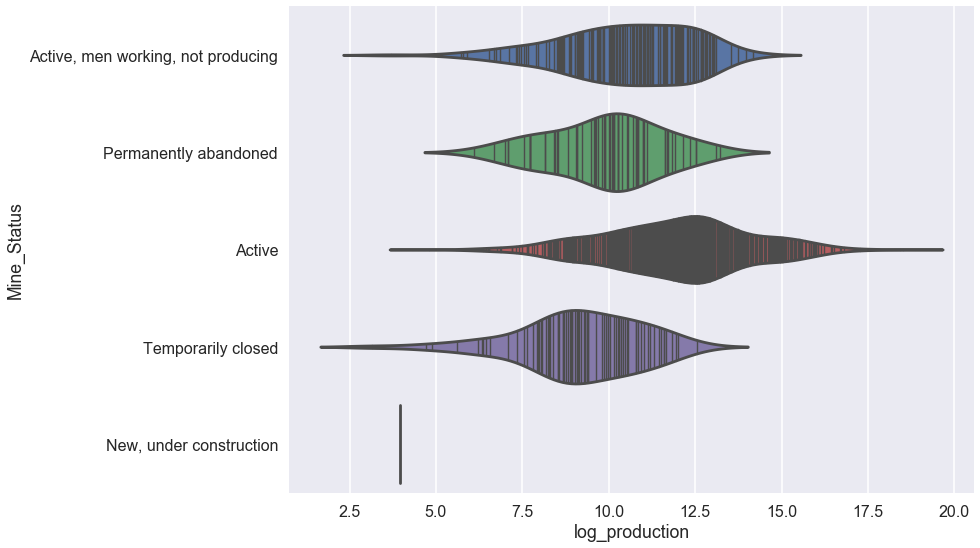

In [4]:
sns.set_context('poster')
fig = plt.subplots(figsize=(14,8))
sns.violinplot(y='Mine_Status', x="log_production", data=df, split=True, inner="stick");
plt.tight_layout()
plt.savefig("../figures/Coal_Production_Prediction_Mine_Status_vs_log_Production.png")

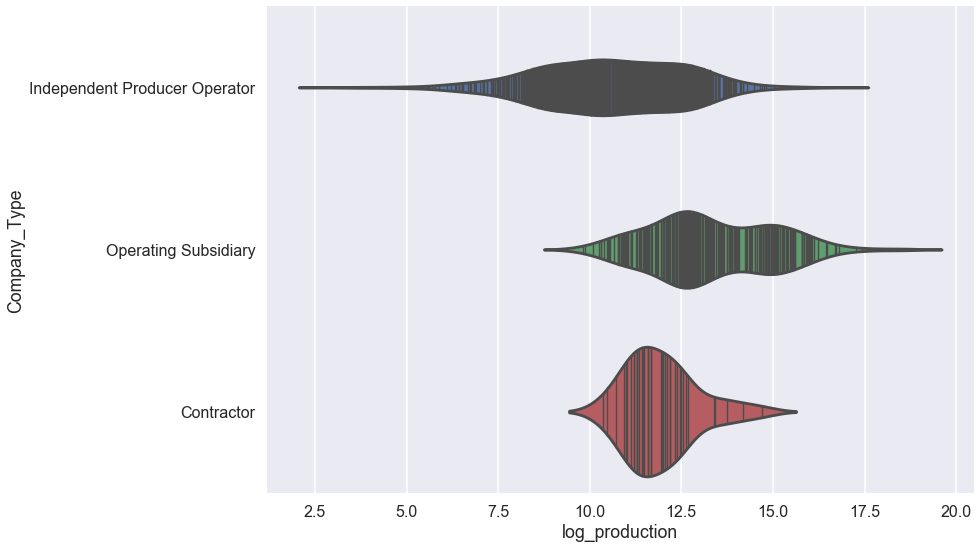

In [5]:
sns.set_context('poster')
fig = plt.subplots(figsize=(14,8))
sns.violinplot(y='Company_Type', x="log_production", data=df, split=True, inner="stick");
plt.tight_layout()
plt.savefig("../figures/Coal_Production_Prediction_Company_Type_vs_log_Production.png")

In [6]:
dummy_categoricals = []
for categorical in categorials:
    print categorical, len(df[categorical].unique())
    # avoid the dummy variable trap!
    drop_var = sorted(df[categorical].unique())[-1]
    temp_df = pd.get_dummies(df[categorical], prefix=categorical)
    df = pd.concat([df, temp_df], axis=1)
    temp_df.drop('_'.join([categorical, str(drop_var)]), axis=1, inplace=True)
    dummy_categoricals += temp_df.columns.tolist()

Mine_State 29
Mine_County 164
Mine_Status 5
Mine_Type 3
Company_Type 3
Operation_Type 2
Operating_Company 752
Operating_Company_Address 692
Union_Code 7
Coal_Supply_Region 8


# Build random forest regressor

In [7]:
train, test = train_test_split(df, test_size=0.3)

In [8]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True)
rf.fit(train[features + dummy_categoricals], train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

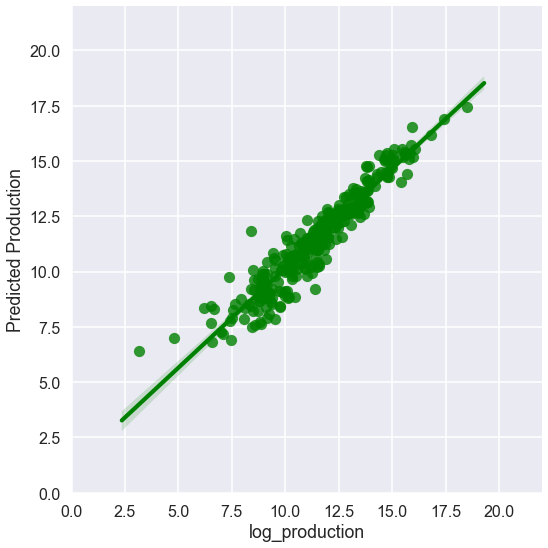

In [9]:
fig = plt.subplots(figsize=(8,8))
sns.regplot(test[target], rf.predict(test[features + dummy_categoricals]), color='green')
plt.ylabel('Predicted Production')
plt.xlim(0,22)
plt.ylim(0,22)
plt.tight_layout()
plt.savefig("../figures/Coal_Production_Prediction_RF_Prediction.png")

In [10]:
predicted = rf.predict(test[features + dummy_categoricals])
print "R^2 score", r2_score(test[target], predicted)

R^2 score 0.900442373451


In [11]:
print "Explained variance", explained_variance_score(test[target], predicted)

Explained variance 0.900442722355


In [12]:
print "MSE", mean_squared_error(test[target], predicted)

MSE 0.517706514947


In [13]:
rf_importances = pd.DataFrame({'name':train[features + dummy_categoricals].columns, 
                               'importance':rf.feature_importances_
                             }).sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_importances.head(5)

,importance,name
0,0.803333,Labor_Hours
1,0.069395,Average_Employees
2,0.009607,Coal_Supply_Region_Powder River Basin
3,0.006403,Mine_Type_Surface
4,0.003830,Coal_Supply_Region_Illinois Basin


# Conclusion

Fun example